# Relax Inc. Take Home Challenge

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime

from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,train_test_split

# Data

In [2]:
df_engage=pd.read_csv('takehome_user_engagement.csv',index_col='time_stamp')
df_engage.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [3]:
df_user=pd.read_csv('takehome_users.csv',encoding='latin-1')
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
df_engage.info()

<class 'pandas.core.frame.DataFrame'>
Index: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  207917 non-null  int64
 1   visited  207917 non-null  int64
dtypes: int64(2)
memory usage: 4.8+ MB


# Data Cleaning

We need to check weekly log in counts

In [6]:
df_engage.index=pd.to_datetime(df_engage.index)

In [7]:
df_week=df_engage.groupby('user_id').resample('1W').sum()
df_week=df_week.drop('user_id',axis=1)
df_week.head(10)

visited
user_id time_stamp         
1       2014-04-27        1
2       2013-11-17        1
        2013-11-24        0
        2013-12-01        1
        2013-12-08        0
        2013-12-15        1
        2013-12-22        0
        2013-12-29        1
        2014-01-05        1
        2014-01-12        1

Let's find users who have logged into the product on 3 separete days in at least one week period.

In [8]:
active_users=df_week[df_week.visited>=3]
active_users=active_users.reset_index(level='time_stamp')
active_users['active_weeks']=1
active_users.head()

,time_stamp,visited,active_weeks
user_id,,,
2,2014-02-09,3,1
10,2013-03-03,3,1
10,2013-04-14,3,1
10,2013-04-28,3,1
10,2013-05-05,4,1


In [9]:
active_users=active_users['active_weeks'].groupby('user_id').sum()
active_users=pd.DataFrame(active_users)
active_users=active_users.reset_index()
active_users.head()

,user_id,active_weeks
0,2,1
1,10,52
2,20,1
3,33,1
4,42,68


Now, we combine two tables on user_id

In [10]:
df_user.rename(columns = {'object_id':'user_id'}, inplace = True)

In [11]:
result=pd.merge(df_user,active_users,how='left',on='user_id')
result.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_weeks
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,NaN
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,NaN
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,NaN
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,NaN


In [12]:
#lets put 1 for acive users and 0 for pasif users.
result['active_weeks'].fillna(0, inplace=True)
result['active_weeks']=result['active_weeks'].apply(lambda x: 1 if x!=0 else 0)

In [13]:
result['invited_by_user_id'].fillna(0, inplace=True)
result['invited_by_user_id']=result['invited_by_user_id'].apply(lambda x: 1 if x!=0 else 0)

In [14]:
# set creation_time
result.creation_time = pd.to_datetime(result.creation_time)
result['last_session_creation_time'] = result['last_session_creation_time'].map(lambda data: 
                                    datetime.datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),
                                                                              na_action='ignore')
result['last_session_creation_time'] = pd.to_datetime(result['last_session_creation_time'])

In [15]:
result['last_session_creation_time'] = pd.to_datetime(result['last_session_creation_time'])
#subtract to find time active
result['usage_length'] = result['last_session_creation_time'] - result['creation_time']
#lets settle for seconds instead of days to make the time differences more distinct
result['usage_length'] = [x.total_seconds() for x in result['usage_length']]
result['usage_length']=result['usage_length'].apply(lambda x: x if x>0 else 0)
result['usage_length'] = result['usage_length'].fillna(0)

In [16]:
#drop unnecessary columns
data_model = result.drop([ 'name', 'email','last_session_creation_time','creation_time'],axis=1)

In [17]:
#convert invited_by_user_id column to binary
data_model['invited_by_user_id'] = data_model['invited_by_user_id'].fillna(0)
data_model['invited_by_user_id'] = data_model['invited_by_user_id'].apply(
        lambda x: 1 if x!=0 else 0)

In [18]:
data_model=data_model.set_index('user_id').sort_index()
data_model.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_weeks,usage_length
user_id,,,,,,,
1,GUEST_INVITE,1,0,11,1,0,0.0
2,ORG_INVITE,0,0,1,1,1,11736000.0
3,ORG_INVITE,0,0,94,1,0,0.0
4,GUEST_INVITE,0,0,1,1,0,72000.0
5,GUEST_INVITE,0,0,193,1,0,414000.0


In [19]:
#encode object columns and org_id column
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
creation = gle.fit_transform(data_model['creation_source'])
data_model.creation_source = creation

org_id = gle.fit_transform(data_model['org_id'])
data_model.org_id = org_id
data_model.head(10)

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_weeks,usage_length
user_id,,,,,,,
1,0,1,0,11,1,0,0.0
2,1,0,0,1,1,1,11736000.0
3,1,0,0,94,1,0,0.0
4,0,0,0,1,1,0,72000.0
5,0,0,0,193,1,0,414000.0
6,0,0,0,197,1,0,154800.0
7,3,0,1,37,0,0,327600.0
8,2,1,1,74,0,0,0.0
9,2,0,0,302,0,0,0.0


In [20]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             12000 non-null  int64  
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   org_id                      12000 non-null  int64  
 4   invited_by_user_id          12000 non-null  int64  
 5   active_weeks                12000 non-null  int64  
 6   usage_length                12000 non-null  float64
dtypes: float64(1), int64(6)
memory usage: 750.0 KB


# Modeling

In [21]:
X = data_model.drop('active_weeks',axis=1)
y = data_model['active_weeks']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,random_state=123)

In [22]:
parameters = {
    'max_depth':[3,5,8],
    'subsample':[1,0.8],
    'learning_rate': [0.25, 0.2, 0.1]
    }

# Instantiate a Gradient Boosting Classifier
clf = GradientBoostingClassifier()

# Instantiate the GridSearchCV object
clf_grid = GridSearchCV(clf, param_grid=parameters,scoring='accuracy',cv=5)

# Fit it to the data
clf_grid.fit(X_train, y_train)

# Print the tuned parameters and score
print("Best Parameters: {}".format(clf_grid.best_params_)) 
print("Best accuracy is {}".format(clf_grid.best_score_))

pred= clf_grid.predict(X_test)
score = accuracy_score(y_test, pred)
print("Accuracy score: {}".format(score))

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1}
Best accuracy is 0.9763095238095237
Accuracy score: 0.9772222222222222


# Feature Importance

In [23]:
feature_importance = pd.DataFrame()
feature_importance['pred'] = clf_grid.best_estimator_.feature_importances_
feature_importance = feature_importance.set_index(X.columns)
feature_importance.pred.nlargest(6)

usage_length                  0.985124
org_id                        0.011304
creation_source               0.002963
opted_in_to_mailing_list      0.000292
invited_by_user_id            0.000240
enabled_for_marketing_drip    0.000077
Name: pred, dtype: float64

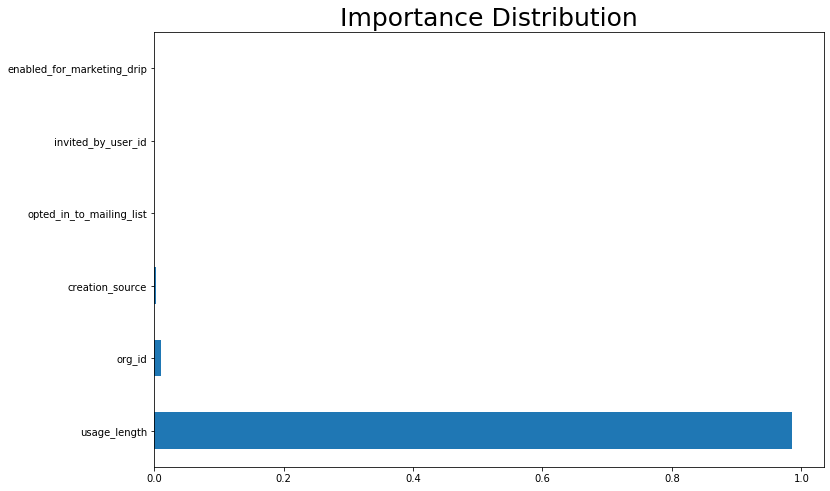

In [24]:
fig, ax = plt.subplots(figsize = (12,8))
(pd.Series(feature_importance['pred'], index=X.columns).nlargest(14).plot(kind='barh'))
ax.set_title('Importance Distribution',fontsize=25)
plt.show()

# Conclusion

When we predict user login by using Gradient Boosting Classifier, we got 97.72% accuracy. The most important column is
usage_length which we create this column by subtracting account creation time from last log in time.